In [1]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [3]:
path = '/content/SMSSpamCollection'
messages = pd.read_csv(path, sep ='\t',names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [4]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


The output shows that, our message count is 5572, where 2 unique labels are "spam" and "ham" , and unique message count is 5169, as rest are repeated ones. The top label is 'ham' and top message is 'Sorry, I'll call later'.

In [5]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [6]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [7]:
# Get all the ham and spam messages
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

# Create numpy list to visualize using wordcloud
ham_msg_txt = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_txt = " ".join(spam_msg.message.to_numpy().tolist())

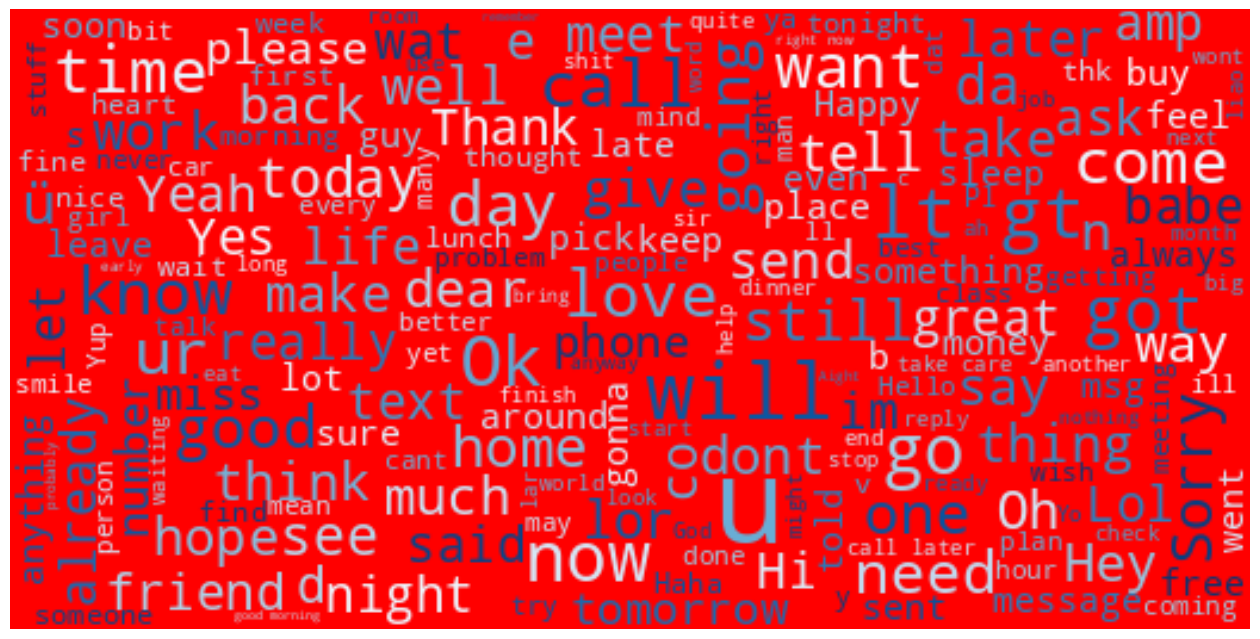

In [9]:
# wordcloud of ham messages
ham_msg_wcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="red", colormap='Blues').generate(ham_msg_txt)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_wcloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

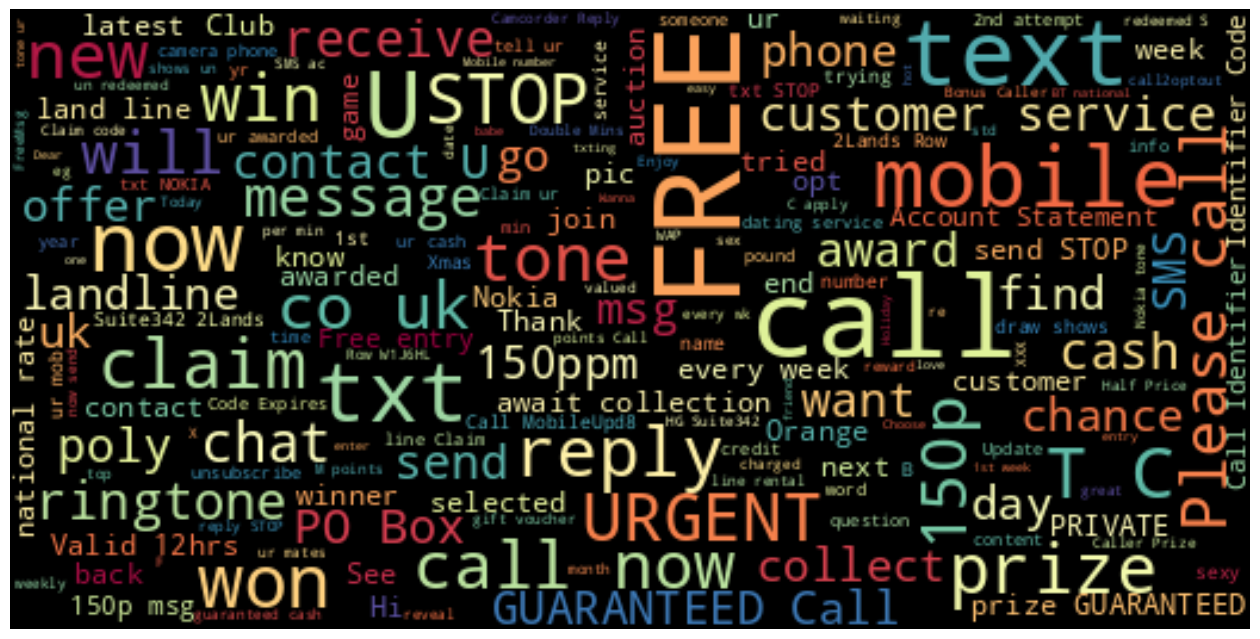

In [10]:
# wordcloud of spam messages
spam_msg_wcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Spectral_r').generate(spam_msg_txt)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_wcloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

In [11]:
#visualize imbalanced data
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.4818%

ValueError: ignored

<Figure size 800x600 with 0 Axes>

In [12]:
# one way to fix imbalanced data is to downsample the ham message count to the spam message count
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg

#check the shape now, it must be te same!
print(ham_msg_df.shape, spam_msg_df.shape)

#check graph for better visualization
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam messages (after downsampling)')
plt.xlabel('Message labels')

(747, 2) (747, 2)


<ipython-input-12-04e2e44356ef>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)


ValueError: ignored

<Figure size 800x600 with 0 Axes>

In [13]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

<ipython-input-13-2383c6717b7e>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  labels = msg_df.groupby('label').mean()


,text_length
label,
ham,73.238286
spam,138.670683


In [14]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [15]:
# Defining pre-processing hyperparameters
max_len = 50
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
vocab_size = 500

In [16]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [17]:
# Get the word_index
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [18]:
# check how many unique tokens are present
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4169 unique tokens in training data. 


In [19]:
# Sequencing and padding
#train
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

#test
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,padding = padding_type, truncating = trunc_type)

The Dense Sequential Spam Detection Model-

In [20]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [21]:
#Dense Sequential model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

In [23]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [24]:
# fit dense seq model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 13s - loss: 0.6909 - accuracy: 0.6519 - val_loss: 0.6866 - val_accuracy: 0.8595 - 13s/epoch - 329ms/step
Epoch 2/30
38/38 - 3s - loss: 0.6790 - accuracy: 0.8536 - val_loss: 0.6699 - val_accuracy: 0.8528 - 3s/epoch - 76ms/step
Epoch 3/30
38/38 - 2s - loss: 0.6457 - accuracy: 0.8686 - val_loss: 0.6189 - val_accuracy: 0.8462 - 2s/epoch - 54ms/step
Epoch 4/30
38/38 - 2s - loss: 0.5718 - accuracy: 0.8812 - val_loss: 0.5317 - val_accuracy: 0.8495 - 2s/epoch - 40ms/step
Epoch 5/30
38/38 - 1s - loss: 0.4687 - accuracy: 0.8870 - val_loss: 0.4367 - val_accuracy: 0.8528 - 1s/epoch - 33ms/step
Epoch 6/30
38/38 - 1s - loss: 0.3752 - accuracy: 0.8912 - val_loss: 0.3607 - val_accuracy: 0.8763 - 717ms/epoch - 19ms/step
Epoch 7/30
38/38 - 1s - loss: 0.3038 - accuracy: 0.9038 - val_loss: 0.3061 - val_accuracy: 0.8863 - 704ms/epoch - 19ms/step
Epoch 8/30
38/38 - 2s - loss: 0.2523 - accuracy: 0.9213 - val_loss: 0.2653 - val_accuracy: 0.8930 - 2s/epoch - 42ms/step
Epoch 9/30
38/38 - 1s -

In [25]:
# Model performance on test data
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 4ms/step - loss: 0.1277 - accuracy: 0.9431


[0.12772072851657867, 0.9431437849998474]

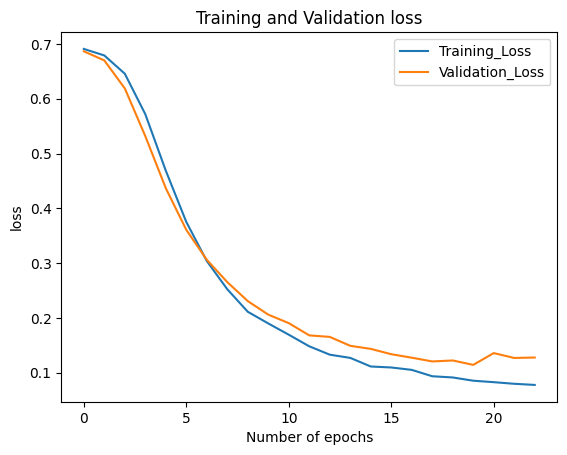

In [26]:
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

Long Short Term Memory (LSTM) Model

In [27]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2

In [28]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

In [29]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [30]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30


ValueError: ignored

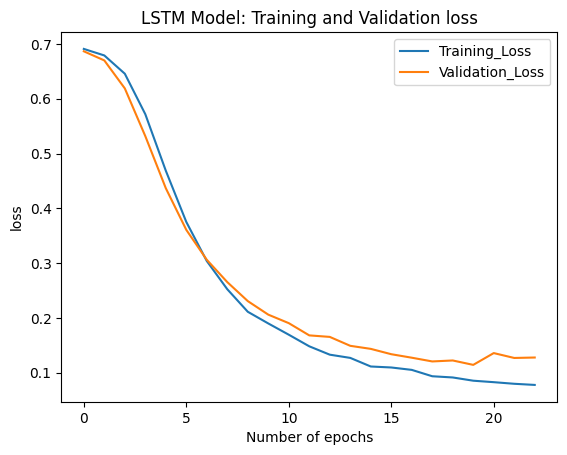

In [31]:
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

Bi-LSTM Model

In [32]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

In [33]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [34]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels, epochs=num_epochs,
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30


ValueError: ignored

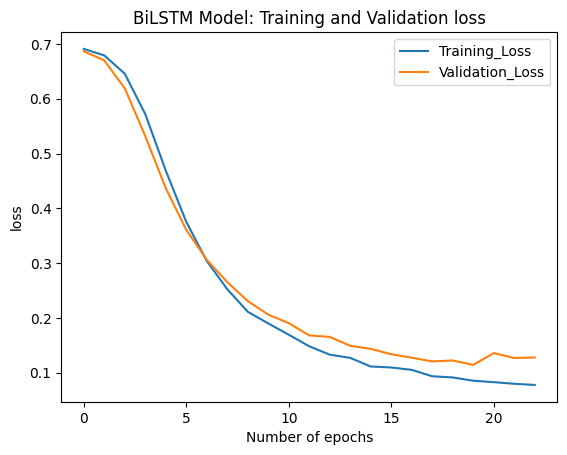

In [35]:
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

In [36]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 3ms/step - loss: 0.1277 - accuracy: 0.9431
Dense architecture loss and accuracy: [0.12772072851657867, 0.9431437849998474] 


ValueError: ignored

In [37]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))
predict_spam(predict_msg)

1/1 [==============================] - 0s 78ms/step


array([[0.02175006],
       [0.00941393],
       [0.99971265]], dtype=float32)